 ## Here, we will optimize the segmentation mask to better the inpainting afterwards

In [3]:
# Import necessary dependencies
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image
import logging


# Import Ikomia API
from ikomia.dataprocess.workflow import Workflow
from ikomia.dataprocess import CImageIO, CInstanceSegmentationIO
from ikomia.core import CWorkflowTaskIO, IODataType

# Import the custom modules
from simple_lama_inpainting import SimpleLama
# from diffusers import StableDiffusionInpaintPipeline
# import transformers

# Import the necessary classes
from detectors import RedCapDetector 
from detectors import YOLODetector
from segmentors import YoloSegmentor
from segmentors import FlorenceSegmentor
from removers import BlurringRemover
from removers import LamaInpaintingRemover


# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarnin

In [22]:
%matplotlib inline

In [5]:
def imshow(image, cmap=None):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb, cmap)
  plt.axis('off')  # Hide axis for better visualization
  plt.show()

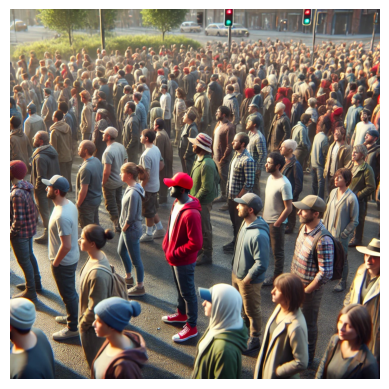

In [6]:
test_image = cv2.imread('_test_data/test1.jpg')
imshow(test_image)

In [11]:
wf = Workflow()
segmentor = wf.add_task(name="infer_yolo_v8_seg", auto_connect=True)

WARNING ⚠️ Python>=3.10 is required, but Python==3.9.18 is currently installed 


In [16]:
@interact(iou_thres = (0, 1, 0.1), conf_thres = (0, 1, 0.1))
def segment_test_params(iou_thres, conf_thres):

    test_image1 = cv2.imread('_test_data/test1.jpg') 
    test_image2 = cv2.imread('_test_data/test2.jpg')
    test_image3 = cv2.imread('_test_data/test3.jpg')
    test_image4 = cv2.imread('_test_data/test4.jpg')  

    segmentor.set_parameters({
    "cuda": str(True),
    "conf_thres": str(conf_thres),
    "iou_thres": str(iou_thres)
    })

    wf.run_on(test_image1)
    output1 = segmentor.get_image_with_mask_and_graphics()

    wf.run_on(test_image2)
    output2 = segmentor.get_image_with_mask_and_graphics()
    
    wf.run_on(test_image3)
    output3 = segmentor.get_image_with_mask_and_graphics()
    
    wf.run_on(test_image4)
    output4 = segmentor.get_image_with_mask_and_graphics()
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(output1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(output2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(output3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(output4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='iou_thres', max=1.0), FloatSlider(value=0.0, descrip…

We saw that with Conf and iou threshold at 0.5 we have a correct segmentation.

## Now, Let's see how we can optimize the segmentation mask

In [7]:
detector = YOLODetector(device="cuda")
segmentor = YoloSegmentor(device="cuda")

WARNING ⚠️ Python>=3.10 is required, but Python==3.9.18 is currently installed 


In [13]:
def get_segmented_image(image):
    boxes = detector.detect(image)
    segmented_image = segmentor.segment(image, boxes)
    return segmented_image

In [14]:
def display_result(image, mask):
    # 1. Original Image
    original_image = image

    # 2. Masked Image (apply mask to the original image)
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # 3. Original Image with Mask Overlay (in red)
    # Create a red overlay for the masked regions
    red_overlay = np.zeros_like(image)
    red_overlay[:, :, 2] = 255  # Set the red channel to max for red color

    # Apply the mask to the red overlay, then combine with the original image
    mask_colored_overlay = cv2.bitwise_and(red_overlay, red_overlay, mask=mask)
    mask_overlay = cv2.addWeighted(image, 0.7, mask_colored_overlay, 0.3, 0)

    # Plot the images
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    
    # Masked Image
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title("Masked Image")
    plt.axis("off")
    
    # Original Image with Red Mask Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(mask_overlay, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Red Mask Overlay")
    plt.axis("off")
    
    plt.show()


In [15]:
logging.getLogger().setLevel(logging.ERROR)

mask = get_segmented_image(test_image)
display_result(test_image, mask)

Workflow Untitled run successfully in 32.825316 ms.



0: 640x640 1 person, 20.3ms
Speed: 0.8ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Workflow Untitled run successfully in 304.562215 ms.


In [16]:
# Now i want to modify the mask so i takes into account the shadow of the person as well as a bit details 

def enhance_mask(image, mask):
    # 1. Dilate the Mask to Capture Surrounding Area
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size based on shadow size
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)



    # 2. Edge Detection for Detail Enhancement
    edges = cv2.Canny(image, 100, 200)  # Perform Canny edge detection
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)  # Dilate edges for visibility
    enhanced_mask = cv2.bitwise_or(dilated_mask, edges_dilated)  # Combine with dilated mask

    # 3. Brightness Adjustment for Shadows (if necessary)
    # Convert to grayscale and threshold to detect darker regions (shadows)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, shadow_mask = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold for shadows
    shadow_mask = cv2.bitwise_and(shadow_mask, mask)  # Combine with initial mask
    enhanced_mask = cv2.bitwise_or(enhanced_mask, shadow_mask)

    return enhanced_mask, dilated_mask, edges, edges_dilated, shadow_mask

In [17]:
def extract_shadow_mask(image, person_mask):
    # Convert the image to grayscale to detect dark regions
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to detect dark areas (potential shadows)
    _, shadow_candidates = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold as needed

    # Dilate the person mask to find areas near the person that might contain the shadow
    kernel = np.ones((5, 5), np.uint8)
    dilated_person_mask = cv2.dilate(person_mask, kernel, iterations=5)

    # Find the bounding box of the person in the mask
    y_indices, x_indices = np.where(person_mask > 0)
    top_y, bottom_y = min(y_indices), max(y_indices)
    middle_y = (top_y + bottom_y) // 2  # Middle y-coordinate

    # Only keep the shadow mask below the middle y-coordinate
    shadow_mask_inter = cv2.bitwise_and(shadow_candidates, dilated_person_mask)
    shadow_mask = cv2.bitwise_and(shadow_mask_inter, dilated_person_mask)

    # Create a mask that only keeps the area below the middle y-coordinate
    height, width = shadow_mask.shape
    below_middle_mask = np.zeros((height, width), dtype=np.uint8)
    below_middle_mask[middle_y:, :] = 255  # Keep only below the middle y-coordinate

    # Apply this mask to keep only the shadow below the middle y-coordinate
    shadow_mask = cv2.bitwise_(shadow_mask, below_middle_mask)

    # Return each intermediate step for debugging or further analysis
    return shadow_mask, shadow_candidates, shadow_mask_inter, dilated_person_mask, below_middle_mask


In [35]:
def extract_shadow_mask_bis(image, person_mask):
    # # Convert the image to grayscale to detect dark regions
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # # Threshold the grayscale image to detect dark areas (potential shadows)
    # _, shadow_candidates = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV)

    # Dilate the person mask to find areas near the person that might contain the shadow
    kernel = np.ones((4, 4), np.uint8)
    dilated_person_mask = cv2.dilate(person_mask, kernel, iterations=5)

    # Dilate the person mask to find areas near the person that might contain the shadow
    kernel1 = np.ones((8, 8), np.uint8)
    dilated_person_mask1 = cv2.dilate(person_mask, kernel1, iterations=5)

    # Find the bounding box of the person in the mask
    y_indices, x_indices = np.where(person_mask > 0)
    top_y, bottom_y = min(y_indices), max(y_indices)
    middle_y = (top_y + bottom_y) // 2  # Middle y-coordinate

    # Only keep the shadow mask below the middle y-coordinate
    dilated_person_mask1[:middle_y, :] = 0
    dilated_person_mask[middle_y:, :] = 0

    # Apply this mask to keep only the shadow below the middle y-coordinate
    shadow_mask = cv2.bitwise_or(dilated_person_mask1, dilated_person_mask)

    # Dilate the person mask to find areas near the person that might contain the shadow
    kernel = np.ones((2, 2), np.uint8)
    shadow_mask_final= cv2.dilate(shadow_mask, kernel, iterations=5)



    # Plot each intermediary step
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(2, 3, 2)
    plt.imshow(dilated_person_mask1, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(shadow_mask, cmap='gray')
    plt.title("Shadow mask1")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(dilated_person_mask, cmap='gray')
    plt.title("Dilated Person Mask")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(shadow_mask_final, cmap='gray')
    plt.title("Final Shadow Mask")
    plt.axis("off")



    plt.show()

    # Return each intermediate step for further analysis if needed
    return shadow_mask_final


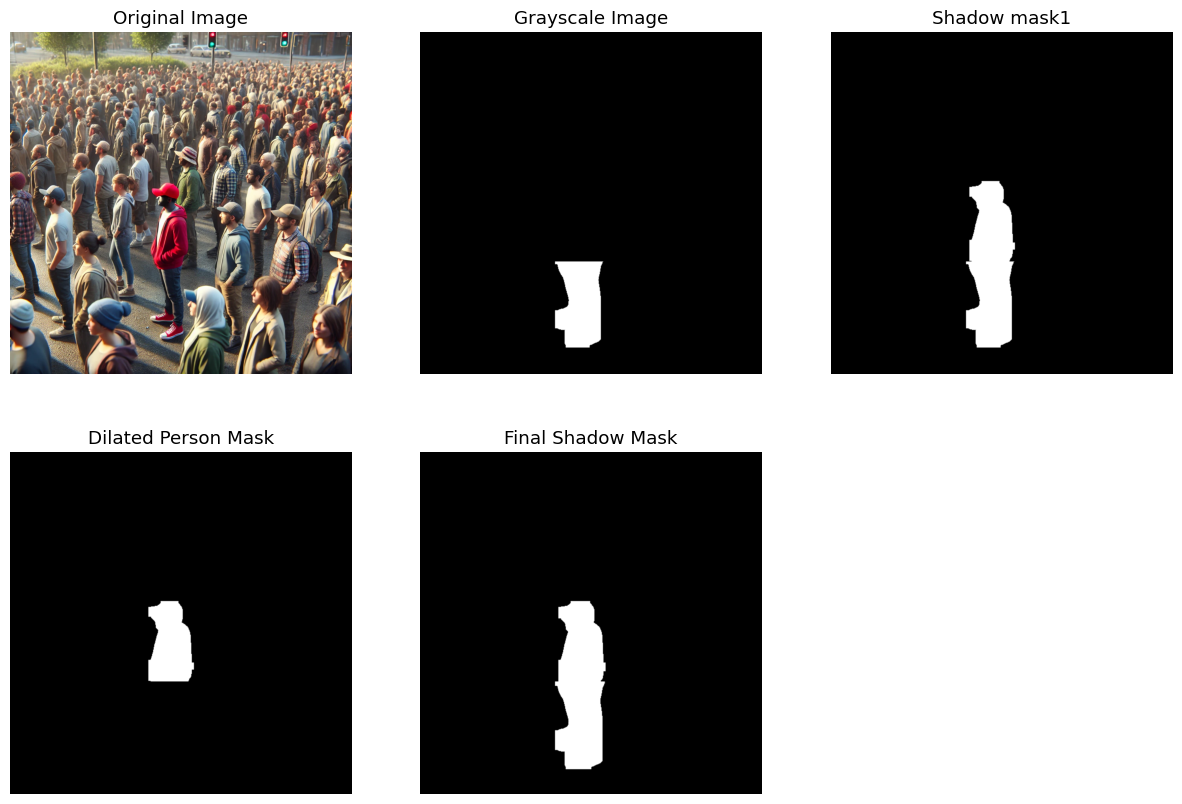

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [36]:
extract_shadow_mask_bis(test_image, mask)

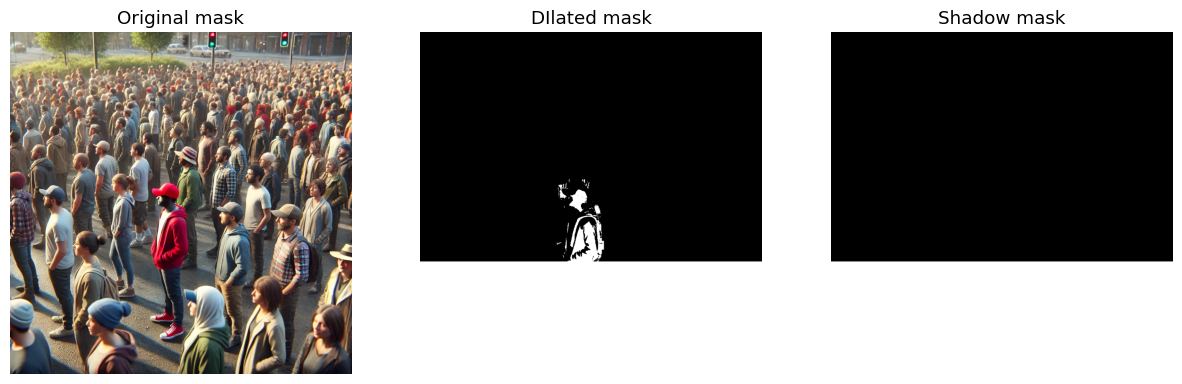

In [44]:
shadow_mask, shadow_candidates, shadow_mask_inter, dilated_person_mask, below_middle_mask  = extract_shadow_mask(test_image, mask)

# display_result(test_image, dilated_mask)
# displau the different masks only
# Plot the images
plt.figure(figsize=(15, 5))
    
# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Original mask")
plt.axis("off")
    
# Masked Image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(shadow_mask, cv2.COLOR_BGR2RGB))
plt.title("DIlated mask")
plt.axis("off")
    
# Original Image with Red Mask Overlay
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(below_middle_mask, cv2.COLOR_BGR2RGB))
plt.title("Shadow mask")
plt.axis("off")
    
plt.show()
